<a href="https://colab.research.google.com/github/miguelzaga/Machine-Learning-Techniques/blob/main/Lab_2/Laboratorio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](./img.png)

Práctica No. 2
==============

*Clasificación de imágenes satelitales con SVM*
--------------------------------------------------------------------

Objetivos
---------

-   Familiarizarse con el algoritmo de SVM.
-   Resolver un problema de clasificación de imágenes satelitales y evaluar métricas de desempeño.


Problema
--------

-   En esta ocasión, trabajaremos con el dataset "EuroSat Dataset". Este conjunto de datos se utiliza para clasificar el uso de la tierra en imágenes geoespaciales.

Este conjunto de datos contiene imágenes que pertenecen al conjunto de datos: [EuroSat Dataset](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset).

**EuroSAT** → Contiene imágenes RGB recopiladas del conjunto de datos Sentinel.

Cada imagen tiene 64x64 píxeles con una distancia de muestreo en el suelo de 10 mt y se encuentran en formato jpg

Para este laboratorio trabajatemos con el fin de facilitar el procesamiento utilizaremos un subconjunto de los datos de la carpeta EuroSAT que se encuentra en el repositorio de Github [EuroSat](https://github.com/hectormelo/Machine-Learning-Techniques/tree/main/Lab_2) y del cual utilizaremos las siguientes carpetas de clases diferentes de imágenes:

1. Forest
2. Industrial
3. PermanentCrop
4. Residential
5. River




### 0. Importación de Librerías

Para este ejercicio, utilizaremos las siguientes librerías.

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial

from PIL import Image #Librería para abrir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO


#### 1. Carga y exploración de los datos

Para éste caso vamos a utilizar la imágenes que se encuentran en un archivo zip en el siguiente enlace:

https://github.com/hectormelo/Machine-Learning-Techniques/blob/main/Lab_2/EuroSAT.zip

La idea es descomprimir el archivo en el entorno de trabajo para poder trabajar con ellas.

In [2]:
file = './EuroSAT3.zip'
with ZipFile(file) as zip_file:
    zip_file.extractall('./EuroSAT')

In [1]:
# URL del archivo ZIP en el repositorio de GitHub
# url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Descargar el archivo ZIP
# response = requests.get(url)
# zip_content = response.content
# Descomprimir el contenido en memoria
# with ZipFile(BytesIO(zip_content)) as zip_file:
#     zip_file.extractall("/content/data/EuroSAT")  # Especifica el directorio donde quieres descomprimir
# print("Archivo descomprimido.")

Para reducir el tiempo de procesamiento, reduciremos el tamaño de las imágenes de 64X64 a 32X32.

In [3]:
def load_image(folder,width, height):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [5]:
#cargamos las imágenes que se encuentran en EuroSAT
X, y = load_image('./EuroSAT', 32, 32)
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Tamaño de los datos
X.shape

(3750, 32, 32, 3)

In [7]:
# Tamaño de los datos de entrenamiento
x_train.shape

(3000, 32, 32, 3)

In [8]:
# Tamaño de los datos de prueba
x_test.shape

(750, 32, 32, 3)

En total encontramos 3.750 imágenes, de 32x32 en formato RGB, es decir maneja 3 canales (rojo, verde y azul)
El conjunto de entrenamiento queda con 3.000 imágenes y el de test con 750


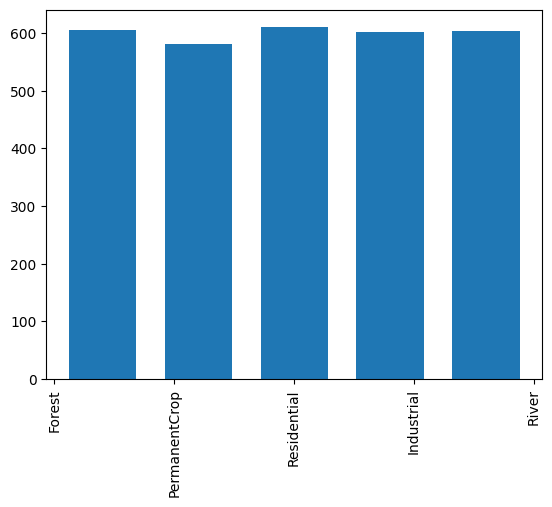

In [9]:
# Observar distribucón de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

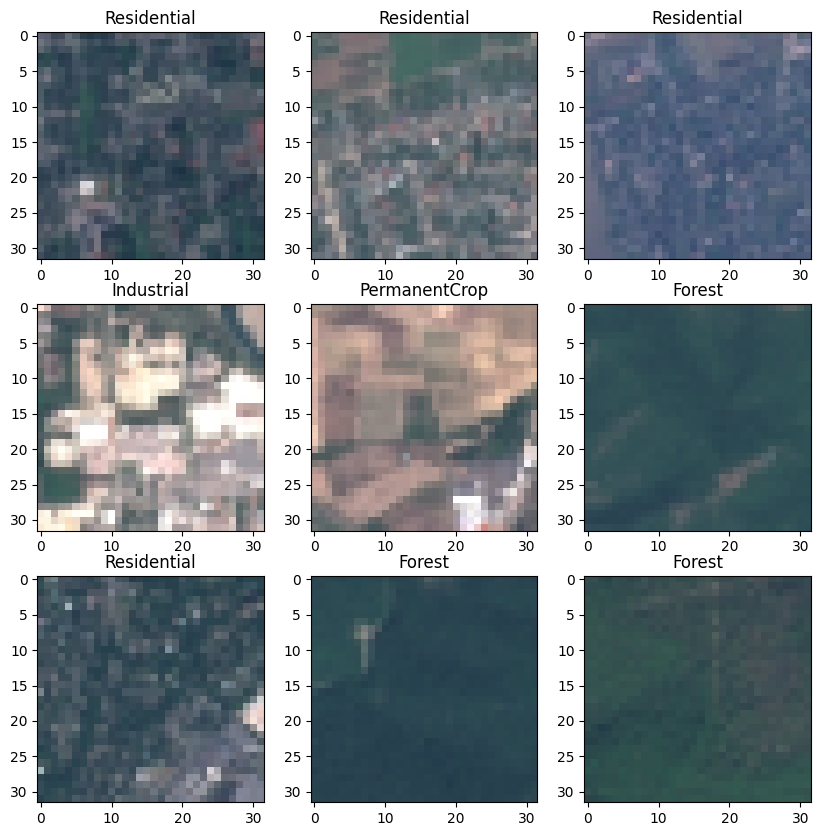

In [10]:
# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

In [11]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 605
Industrial: 601
PermanentCrop: 581
Residential: 610
River: 603

Distribución de los labels de test: 
Forest: 145
Industrial: 149
PermanentCrop: 169
Residential: 140
River: 147


#### 2. Preparación de los Datos

##### 2.1 Estandarizacion

Sabiendo que estamos trabajando con imágenes RGB podríamos hacer estandarización diviendo por 255 (el máximo valor que puede tomar un píxel en una imagen de 8 bits).

Sin embargo, en este caso haremos una aproximación con StandardScaler pues centra los datos en 0 y asegura varianza unitaria. Lo que en algoritmos sensibles a escala como SVM puede ser muy útil.

In [12]:
# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarizar las imágenes
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

##### 2.1 PCA (Principal Component Analysis)

PCA puede ayudarnos a reducir el tiempo de entrenamiento y también puede mejorar el rendimiento del modelo al eliminar características redundantes o poco informativas

In [13]:
# Dimensionalidad de los datos sin PCA
x_train_standard.shape

(3000, 3072)

In [14]:
# Conservar el 95% de la varianza
pca = PCA(0.95).fit(x_train_standard)

In [15]:
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [16]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 95% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 95% de la varianza es: 236


(3000, 236)

#### 3. Modelamiento

En esta sección, emplearemos el algoritmo Support Vector Machine (SVM) para nuestro problema de clasificación de imágenes. SVM es un algoritmo de aprendizaje supervisado que busca encontrar un hiperplano en un espacio N-dimensional (N es el número de características) que clasifique de manera óptima los inputs en categorías.


In [17]:
# Entrenamiento y creación del modelo
start = time.time()

# Vamos a entrenarlos con varios Parámetros de C
# (Queremos un equilibrio entre la capacidad de generalización y la precisión en el conjunto de entrenamiento)
C = [0.1, 1, 10]

# Grid search
grid_search = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid={'C': C}, cv=3, n_jobs=-1)

# Entrenamiento
grid_search.fit(x_train_pca, y_train)

# Tiempo de entrenamiento
end = time.time()

print(f"Tiempo de entrenamiento: {end - start}")

# Mejor modelo
best_model = grid_search.best_estimator_

Tiempo de entrenamiento: 100.16556787490845


In [18]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'C': 0.1}


In [19]:
# Predicciones
y_pred = best_model.predict(x_test_pca)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7173333333333334
               precision    recall  f1-score   support

       Forest       0.84      0.96      0.90       145
   Industrial       0.73      0.70      0.71       149
PermanentCrop       0.74      0.72      0.73       169
  Residential       0.58      0.62      0.60       140
        River       0.68      0.59      0.63       147

     accuracy                           0.72       750
    macro avg       0.71      0.72      0.71       750
 weighted avg       0.72      0.72      0.71       750



Matriz de confusión datos de entrenamiento
Precisión: 0.9026666666666666


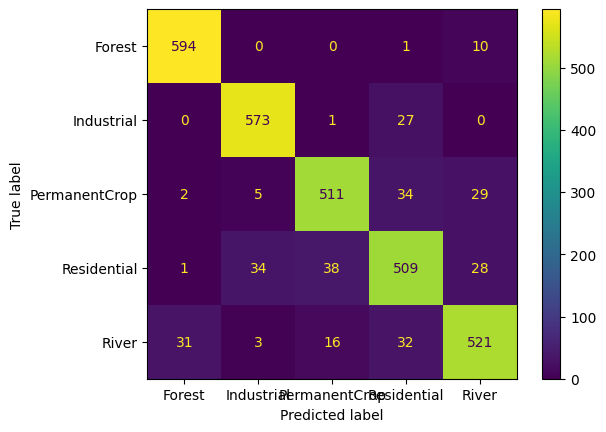

In [20]:
# Observemos la matriz se confusión
print("Matriz de confusión datos de entrenamiento")

print("Precisión:", accuracy_score(y_train, best_model.predict(x_train_pca)))

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, best_model.predict(x_train_pca))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Matriz de confusión datos de test
Precisión: 0.7173333333333334


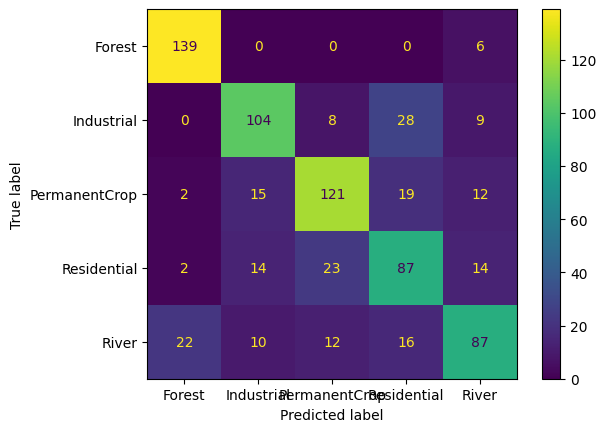

In [21]:
# Matriz de confusión para test
print("Matriz de confusión datos de test")

print("Precisión:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Observemos ejemplos mal clasificados

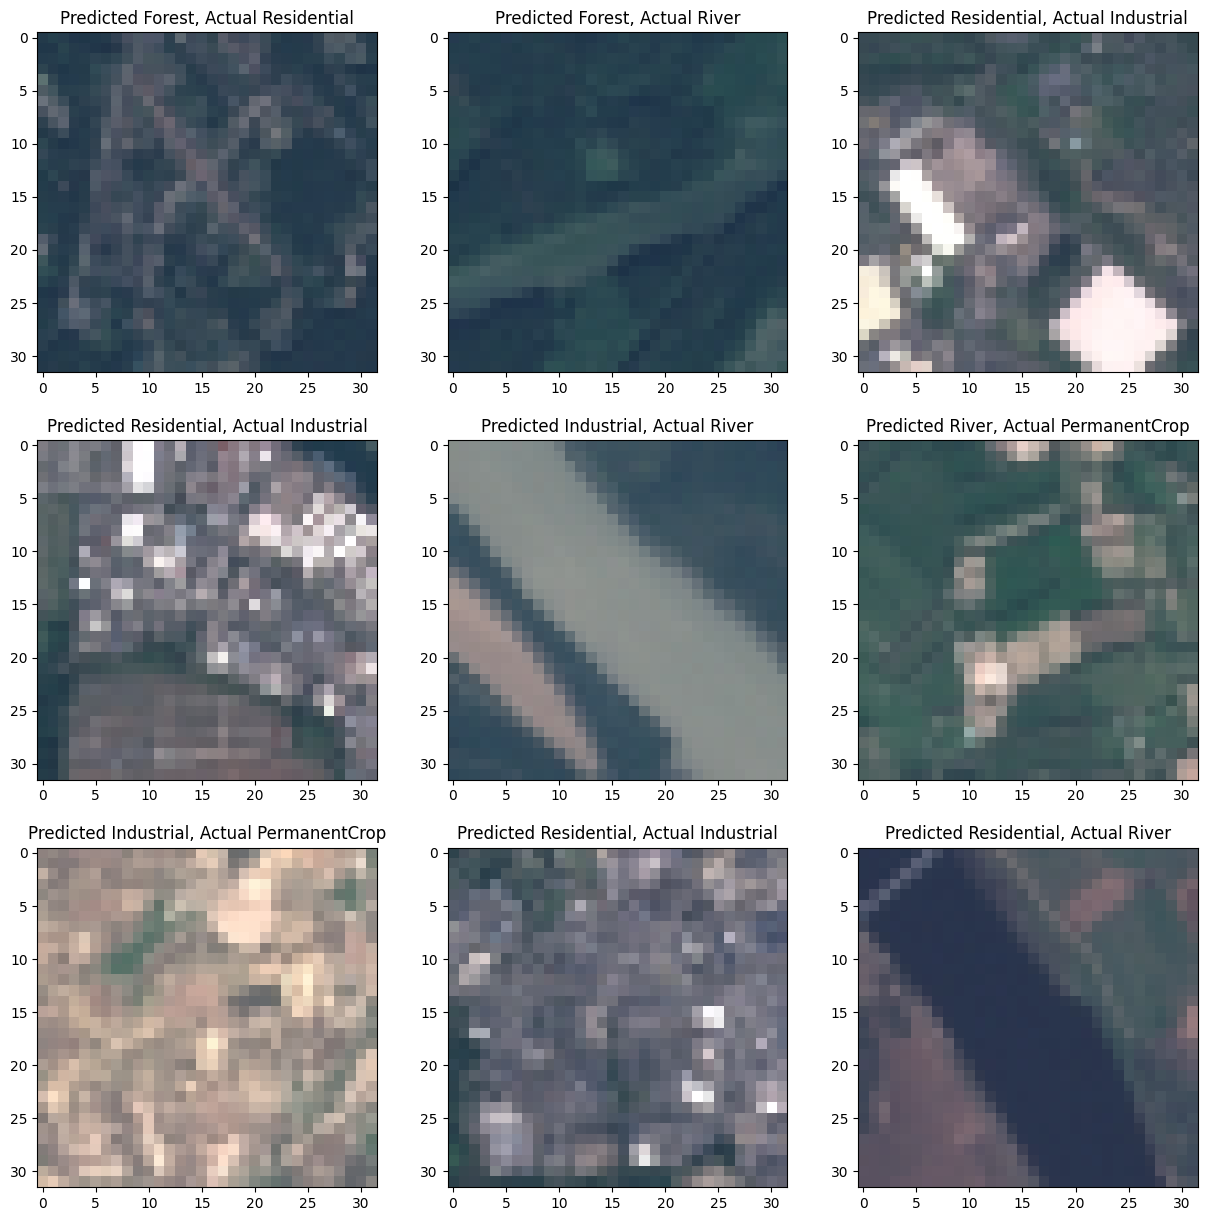

In [22]:
# Gráfico de ejemplos mal clasificados
incorrect_indices = np.nonzero(y_pred != y_test)[0]

rdn_numbers = np.random.choice(incorrect_indices, size=min(len(incorrect_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(incorrect_indices), 9)):
    incorrect = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray')
    plt.title(f"Predicted {y_pred[incorrect]}, Actual {y_test[incorrect]}")
plt.show()

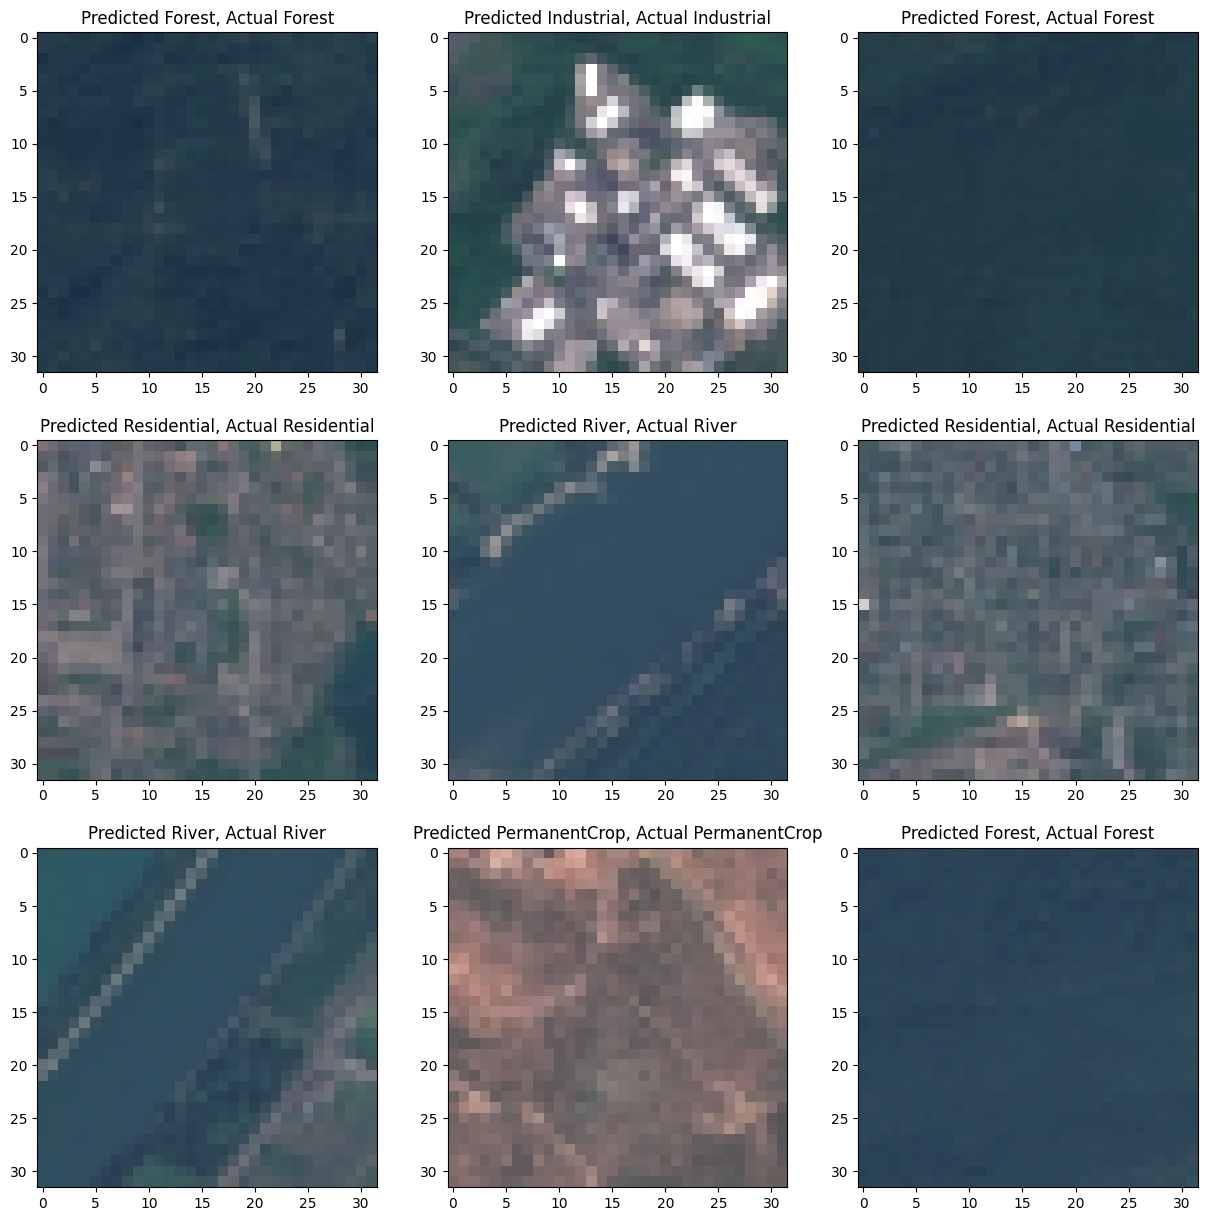

In [23]:
# Gráfico de ejemplos bien clasificados
correct_indices = np.nonzero(y_pred == y_test)[0]

rdn_numbers = np.random.choice(correct_indices, size=min(len(correct_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(correct_indices), 9)):
    correct = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct], cmap='gray')
    plt.title(f"Predicted {y_pred[correct]}, Actual {y_test[correct]}")
plt.show()

####  Preguntas para el análisis
- ¿A qué se debe que el modelo no clasifique correctamente ciertas imágenes?
- ¿Influye el valor del color de los píxeles en la clasificación?
- ¿PCA con una explicación mayor de la variancia puede ayudar a mejorar el desempeño del modelo?
- ¿Qué pasaría si se utiliza un kernel no lineal, como RBF? ¿Cómo se ajustarían los hiperparámetros?

####  Desarrollo
- *¿A qué se debe que el modelo no clasifique correctamente ciertas imágenes?*

    Se debe a que el hiperplano generado por el algoritmo SVM no dividió correctamente las clases. Y posiblemente, precisamente esas imágenes tienen carácteristicas parecidas a otra clase y conllevan a un error en la categorización. Adicionalmente, se usa un kernel lineal y eso evita que el hiperplano pueda distinguir patrones adicionales.

- *¿Influye el valor del color de los píxeles en la clasificación?*

    Lo más probable es que sí. Ya que el color representa tres dimensiones de los datos iniciales de la imagen: (32 * 32 * **3**). Al aplanar estas carácteristicas (3072) y luego transformarlas con PCA (236), si efectivamente parte de la varianza de debe al color, se va a ver representado en alguno de los componentes principales. Pero no se puede asociar un componente principal con "valor del color". Si pudieramos, el coeficiente de tal componente nos mostraría la influencia del color sobre la clasificación.

- *¿PCA con una explicación mayor de la variancia puede ayudar a mejorar el desempeño del modelo?*


In [33]:
pca2 = PCA(0.99).fit(x_train_standard)
x_train_pca2 = pca2.transform(x_train_standard)
x_test_pca2 = pca2.transform(x_test_standard)
print(f"El número de componente principales que conservan el 99% de la varianza es: {pca2.n_components_}")

El número de componente principales que conservan el 99% de la varianza es: 633


In [34]:
start = time.time()

C = [0.1, 1, 10]
grid_search2 = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid={'C': C}, cv=3, n_jobs=-1)
grid_search2.fit(x_train_pca2, y_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end - start}")

best_model2 = grid_search2.best_estimator_

Tiempo de entrenamiento: 17.702319145202637


In [35]:
best_params2 = grid_search2.best_params_
print(f"Mejores parámetros: {best_params2}")

Mejores parámetros: {'C': 0.1}


In [36]:
y_pred2 = best_model2.predict(x_test_pca2)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.66
               precision    recall  f1-score   support

       Forest       0.83      0.98      0.90       145
   Industrial       0.76      0.62      0.68       149
PermanentCrop       0.62      0.69      0.66       169
  Residential       0.43      0.45      0.44       140
        River       0.65      0.55      0.60       147

     accuracy                           0.66       750
    macro avg       0.66      0.66      0.65       750
 weighted avg       0.66      0.66      0.66       750



Al aumentar la varianza explicada por los componentes principales disminuyó el desempeño del modelo ("accuracy": de 0.71 a 0.66). Lo que implica un "overfit". 

- *¿Qué pasaría si se utiliza un kernel no lineal, como RBF? ¿Cómo se ajustarían los hiperparámetros?*

In [46]:
start = time.time()

C = [0.1, 1, 10]
gamma = [0.0001, 0.001, 0.01, 1, 10]
grid_search3 = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid={'C': C, 'gamma': gamma}, cv=3, n_jobs=-1)
grid_search3.fit(x_train_pca, y_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end - start}")

best_model3 = grid_search3.best_estimator_

Tiempo de entrenamiento: 38.86569595336914


In [47]:
best_params3 = grid_search3.best_params_
print(f"Mejores parámetros: {best_params3}")

Mejores parámetros: {'C': 1, 'gamma': 0.001}


In [48]:
y_pred3 = best_model3.predict(x_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy: 0.8386666666666667
               precision    recall  f1-score   support

       Forest       0.93      0.98      0.95       145
   Industrial       0.82      0.93      0.87       149
PermanentCrop       0.84      0.73      0.78       169
  Residential       0.74      0.81      0.78       140
        River       0.87      0.76      0.81       147

     accuracy                           0.84       750
    macro avg       0.84      0.84      0.84       750
 weighted avg       0.84      0.84      0.84       750



Los parámetros a ajustar con un kernel no lineal son 'C' y 'gamma'. Y mejora completamente el desempeño del modelo.